In [1]:
import cobra
from cobra import Model, Reaction, Metabolite

In [2]:
import mewpy
from mewpy.simulation import SimulationMethod
from mewpy.optimization.evaluation import BPCY,WYIELD
from mewpy.problems import GOUProblem

In [3]:
cd "C:\Users\Asus\Desktop\Bioinformática\2º Semestre\Projeto de Bioinformática e Biologia de Sistemas"

C:\Users\Asus\Desktop\Bioinformática\2º Semestre\Projeto de Bioinformática e Biologia de Sistemas


In [4]:
M_1_2 = cobra.io.read_sbml_model('iJN746_metabolitoscopia.xml')

In [5]:
print('Number of reactions: ',len(M_1_2.reactions))
print('Number of metabolites: ',len(M_1_2.metabolites))
print('Number of genes: ',len(M_1_2.genes))

Number of reactions:  1065
Number of metabolites:  915
Number of genes:  746


### Objective function and biomass flux in the wild type 

In [9]:
objective2 = M_1_2.problem.Objective(
    M_1_2.reactions.BIOMASS_KT_TEMP.flux_expression,
    direction = 'max')

In [10]:
M_1_2.objective = objective2

In [11]:
M_1_2.objective.expression

1.0*BIOMASS_KT_TEMP - 1.0*BIOMASS_KT_TEMP_reverse_d18f7

In [12]:
M_1_2.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
fe2_e,EX_fe2_e,0.0014,0,0.00%
glc__D_e,EX_glc__D_e,8.262,6,87.72%
nh4_e,EX_nh4_e,14.44,0,0.00%
o2_e,EX_o2_e,4.065,0,0.00%
pi_e,EX_pi_e,1.072,0,0.00%
so4_e,EX_so4_e,0.3263,0,0.00%
mhpglu_c,SK_5mthglu_c,0.2744,25,12.14%
dna5mtc_c,SK_dna5mtc_c,0.007,11,0.14%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-2.919,1,28.15%


In [10]:
for x in M_1_2.reactions:
    print("%s : %s" % (x.id, x.reaction))

EX_gly_e : gly_e --> 
3OAR141 : 3ocmrs7eACP_c + h_c + nadph_c --> 3hcmrs7eACP_c + nadp_c
EX_glyald_e : glyald_e --> 
3OAR160 : 3opalmACP_c + h_c + nadph_c <=> 3hpalmACP_c + nadp_c
3OAR161 : 3ocpalm9eACP_c + h_c + nadph_c --> 3hcpalm9eACP_c + nadp_c
3OAR180 : 3ooctdACP_c + h_c + nadph_c <=> 3hoctaACP_c + nadp_c
3OAR181 : 3ocvac11eACP_c + h_c + nadph_c --> 3hcvac11eACP_c + nadp_c
ACS : ac_c + atp_c + coa_c <=> accoa_c + amp_c + ppi_c
ACt2rpp : ac_p + h_p --> ac_c + h_c
3OAR40 : actACP_c + h_c + nadph_c <=> 3haACP_c + nadp_c
EX_cit_e : cit_e --> 
EX_co2_e : co2_e <=> 
3OAR60 : 3ohexACP_c + h_c + nadph_c <=> 3hhexACP_c + nadp_c
3OAR80 : 3ooctACP_c + h_c + nadph_c <=> 3hoctACP_c + nadp_c
3OAS100 : h_c + malACP_c + ocACP_c --> 3odecACP_c + ACP_c + co2_c
3OAS120 : dcaACP_c + h_c + malACP_c --> 3oddecACP_c + ACP_c + co2_c
3OAS121 : cdec3eACP_c + h_c + malACP_c --> 3ocddec5eACP_c + ACP_c + co2_c
ACtex : ac_e <=> ac_p
3OAS140 : ddcaACP_c + h_c + malACP_c --> 3omrsACP_c + ACP_c + co2_c
ADA : adn_

GLCDpp : glc__D_p + h2o_p + q8_c --> glcn_p + h_p + q8h2_c
GLCNt2rpp : glcn_p + h_p <=> glcn_c + h_c
EX_lys__L_e : lys__L_e --> 
EX_m_xyl_e : m_xyl_e --> 
GLYCL_2 : co2_c + mlthf_c + nadh_c + nh4_c --> gly_c + nad_c + thf_c
GLCNtex : glcn_e <=> glcn_p
GLYCTO1 : glyclt_c + o2_c --> glx_c + h2o2_c
EX_mal__L_e : mal__L_e --> 
GLCOAS : atp_c + coa_c + glutar_c --> adp_c + glutcoa_c + pi_c
EX_met__L_e : met__L_e --> 
GLCOASYNT : S_gtrdhdlp_c + coa_c --> dhlam_c + glutcoa_c
GLYCtex : glyc_e <=> glyc_p
GLYCtpp : glyc_c <=> glyc_p
GLCabcpp : atp_c + glc__D_p + h2o_c --> adp_c + glc__D_c + h_c + pi_c
EX_mso3_e : mso3_e --> 
GLCtex : glc__D_e <=> glc__D_p
GLNS : atp_c + glu__L_c + nh4_c --> adp_c + gln__L_c + h_c + pi_c
HPYRRx : h_c + hpyr_c + nadh_c <=> glyc__R_c + nad_c
GLYK : atp_c + glyc_c --> adp_c + glyc3p_c + h_c
GLYTRS : atp_c + gly_c + trnagly_c --> amp_c + glytrna_c + ppi_c
GLYabcpp : atp_c + gly_p + h2o_c <=> adp_c + gly_c + h_c + pi_c
GLNTRAT : atp_c + gln__L_c + glutrna_gln_c + h2o_

### Objective function and flux of HAA product

In [13]:
objective1 = M_1_2.problem.Objective(
    M_1_2.reactions.R_EX_HAA.flux_expression, 
    direction = 'max')

In [14]:
M_1_2.objective = objective1

In [15]:
M_1_2.objective.expression

1.0*R_EX_HAA - 1.0*R_EX_HAA_reverse_f8213

In [16]:
M_1_2.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
fe2_e,EX_fe2_e,0.001,0,0.00%
glc__D_e,EX_glc__D_e,20,6,96.03%
nh4_e,EX_nh4_e,35.28,0,0.00%
o2_e,EX_o2_e,1.969,0,0.00%
pi_e,EX_pi_e,11.47,0,0.00%
so4_e,EX_so4_e,3.8,0,0.00%
mhpglu_c,SK_5mthglu_c,0.196,25,3.92%
dna5mtc_c,SK_dna5mtc_c,0.005,11,0.04%
Metabolite,Reaction,Flux,C-Number,C-Flux
h2o_e,EX_h2o_e,-91.05,0,0.00%


### Simulations

In [6]:
from mewpy.simulation import get_simulator
simul = get_simulator(M_1_2)

In [12]:
constraints = {'BIOMASS_KT_TEMP': (0.14, 1000)}

# run a pFBA simulation accounting with the new constraint
result = simul.simulate(method='pFBA',constraints=constraints)

result.fluxes['BIOMASS_KT_TEMP']

3.679412427270661

In [8]:
result

objective: 1821.215654869654
Status: OPTIMAL
Constraints: OrderedDict([('BIOMASS_KT_TEMP', (0.14, 1000))])
Method:pFBA

### BCPY simulations to maximize the HAA production

#### RKO problem (Reaction Constraint Problems)

In [5]:
# Define the target
PRODUCT_ID = 'R_EX_HAA'
BIOMASS_ID = 'BIOMASS_KT_TEMP'

# environmental conditions
envcond = {'BIOMASS_KT_TEMP': (0.14, 1000)}

# Optimization objectives

evaluator_1 = BPCY(BIOMASS_ID, PRODUCT_ID, method='pFBA')
evaluator_2 = WYIELD(BIOMASS_ID, PRODUCT_ID)

# build a new reaction deletion problem instance
from mewpy.problems import RKOProblem

problem = RKOProblem(M_1_2, 
               fevaluation=[evaluator_1, evaluator_2], 
               envcond=envcond)


Building modification target list.
Computing essential reactions:


  0%|          | 0/1065 [00:00<?, ?it/s]C:\Users\Asus\anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
100%|██████████| 1065/1065 [00:38<00:00, 27.90it/s]


Running NSGAII


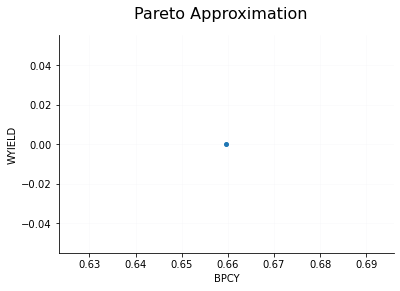

In [19]:
# run the optimization
from mewpy.optimization import EA

ea = EA(problem, max_generations= 50, visualizer=True)
final_pop = ea.run()

In [25]:
# Save the solutions to a csv file
from mewpy.util.io import population_to_csv
population_to_csv(problem,final_pop,'resultsRKOpfba50_HAAcerto.csv')

In [20]:
final_pop[0:50]

[[0.6596871633142856, 0.0];{'PSSA161': 0, 'PSD180': 0}]

####  ROU problem (reaction over- or under expression optimization)

In [21]:
from mewpy.problems import ROUProblem

problem1 = ROUProblem(M_1_2, 
               fevaluation=[evaluator_1, evaluator_2], 
               envcond=envcond)

Building modification target list.
Running NSGAII


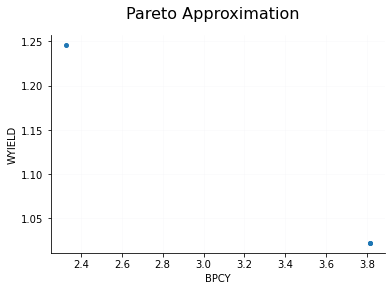

In [22]:
ea1 = EA(problem1, max_generations= 50, visualizer=True)
final_pop1 = ea1.run()

In [24]:
from mewpy.util.io import population_to_csv
population_to_csv(problem1,final_pop1,'resultsROUpfba50_HAAcerto.csv')

In [23]:
final_pop1[0:200]

[[3.815882452097382, 1.0221113711072602];{'ASPO6': 8},
 [4.292101237365567, 0.5748349872277576];{'NADK': 16}]

#### GKO problem (Gene Constraint Problems)

In [6]:
# build a new problem instance
from mewpy.problems import GKOProblem
problem2 = GKOProblem(M_1_2, fevaluation=[
                         evaluator_1, evaluator_2], envcond=envcond)

Building modification target list.
Computing essential genes:


  0%|          | 2/746 [00:00<05:13,  2.37it/s]C:\Users\Asus\anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
100%|██████████| 746/746 [05:47<00:00,  2.15it/s]


Running NSGAII


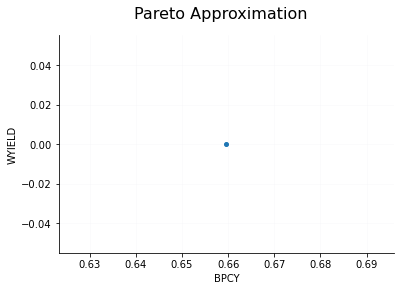

In [29]:
ea2 = EA(problem2, max_generations= 50, visualizer=True)
final_pop2 = ea2.run()

In [30]:
final_pop2[0:50]

[[0.6596231633142853, 0.0];{}]

In [31]:
from mewpy.util.io import population_to_csv

population_to_csv(problem2,final_pop2,'resultsGKOpfba50_HAAcerto.csv')

#### GOU problem (gene over- or under expression optimization)

In [7]:
# build a new problem instance - gene over- or under expression optimization
from mewpy.problems import GOUProblem
problem3 = GOUProblem(M_1_2, fevaluation=[
                         evaluator_1, evaluator_2], envcond=envcond)

Running NSGAII


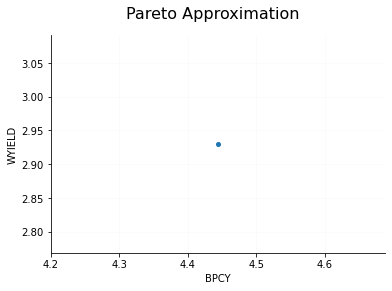

In [ ]:
from mewpy.optimization import EA
ea3 = EA(problem3, max_generations = 50, mp = True, visualizer=True)
final_pop3 = ea3.run()

In [12]:
from mewpy.util.io import population_to_csv

population_to_csv(problem3,final_pop3,'resultsGOUpfba50_HAAcerto.csv')

In [11]:
final_pop3[0:280]

[[4.444262339057959, 2.929738533617709];{'PP_1664': 2},
 [1.5282856674367917, 3.7395016977586133];{'PP_0339': 0, 'PP_2328': 4, 'PP_4965': 0.125},
 [4.1686192040774435, 3.596460692113836];{'PP_2328': 4},
 [4.440298660709159, 3.332214573567277];{'PP_1664': 2, 'PP_0339': 0},
 [4.415626743558746, 3.3683812944509794];{'PP_2186': 0.25, 'PP_1664': 2, 'PP_0339': 0, 'PP_0491': 0.125},
 [4.440298660709447, 3.3322145735672217];{'PP_1457': 0, 'PP_1664': 2},
 [4.44029866070978, 3.332214573567247];{'PP_4401': 0, 'PP_4963': 0.5, 'PP_1457': 0, 'PP_1664': 2, 'PP_0339': 0},
 [4.44029866070978, 3.332214573567247];{'PP_4401': 0, 'PP_3597': 0.25, 'PP_4963': 0.5, 'PP_1664': 2, 'PP_0339': 0},
 [4.44029866070978, 3.332214573567247];{'PP_3597': 0.25, 'PP_4963': 0.5, 'PP_1457': 0, 'PP_1664': 2, 'PP_0339': 0},
 [4.44029866070978, 3.332214573567247];{'PP_4401': 0, 'PP_3597': 0.25, 'PP_4963': 0.5, 'PP_1457': 0, 'PP_1664': 2},
 [4.44029866070978, 3.332214573567247];{'PP_4401': 0, 'PP_3597': 0.25, 'PP_1457': 0, 'PP_